# Project 2 

### Introduction

In this project we will solve a 2D advection-diffusion problem given by

\begin{equation}
    \begin{aligned}
        -\Delta u + \mathbf{v} \cdot \nabla u &= f, \quad &&0 \leq x,y \leq 1 \\
        u &= g,  \quad &&\text{on the boundary.}
    \end{aligned}
    \tag{1}
\end{equation}

To solve this problem we will use three different methods;  GMRES, multigrid V-cycle, and a preconditioned GMRES method using the multigrid V-cycle as a preconditioner. For simplicity, we assume that the velocity field $\mathbf{v} = [v_1, v_2]^T \geq \mathbf{0}$, in the sence that $v_1, v_2 \geq 0$. We also use an equidistant grid with stepsize $h = \frac{1}{N}$, such that $u_{i,j} = u(x_i,y_j) = u(ih,jh)$ and similarly for $f_{i,j}$. For the discretization of the problem we use a 5-point stencil for the diffusion term and an upwind scheme for the advection term, hence we get the following formula

\begin{equation}
    \begin{aligned}
        (4U_{i,j}- U_{i+1,j} - U_{i-1,j} -U_{i,j+1} -U_{i,j-1}) + hv_1(U_{i,j} - U_{i-1,j}) + hv_2(U_{i,j} - U_{i,j-1}) =  h^2f_{i,j}.
    \end{aligned}
    \tag{2}
\end{equation}

For simplicity we choose $\mathbf{v} = [1,1]$ and an excact solution $u(x,y) = \sin(\pi x)\sin(2\pi y)$. By balancing the equation using (1) we get that the right hand sides becomes 

\begin{equation}
    \begin{aligned}
       f(x,y) &= -\Delta u + \mathbf{v} \cdot \nabla u = 5\pi^2 \sin(\pi x)\sin(2\pi y) + \pi \cos(\pi x)\sin(2\pi y) + 2\pi \sin(\pi x)\cos(2\pi y) \\
       g &= 0
    \end{aligned}
    \tag{3}
\end{equation}

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import gmres, LinearOperator
from time import perf_counter

### Task (0)

Now we try and solve the problem for different values of $N$ on the grid, for a random guess U

In [6]:
def lhs_func(U, N, v=np.array([1, 1])):
    """Computes the left-hand side vector based on the input array U for diffusion-advection problem."""
    h = 1 / (N)
    U = np.reshape(U, (N+1, N+1))
    lhs = np.zeros((N + 1, N + 1))
    #Use numpy index to calculate
    index = np.arange(1,N) # indices corresponding to internal nodes
    ixy = np.ix_(index,index)
    ixm_y = np.ix_(index-1,index)
    ixp_y = np.ix_(index+1,index)
    ix_ym = np.ix_(index,index-1)
    ix_yp = np.ix_(index,index+1)
    #Lhs with numpy index
    lhs[ixy] = ((4*U[ixy] - U[ixp_y] - U[ixm_y] - U[ix_yp] - U[ix_ym])
                + h* v[0] * (U[ixy] - U[ixm_y])
                + h* v[1] * (U[ixy] - U[ix_ym]))
    return lhs


In [7]:
def rhs_func(N, v=np.array([1, 1])):
    """Constructs the right-hand side vector f based on the analytical solution u(x, y) = sin(pi x) * sin(2 * pi y)."""
    h = 1 / (N)
    x = np.linspace(0, 1, N + 1)
    y = np.linspace(0, 1, N + 1)
    X, Y = np.meshgrid(x, y)
    
    # Analytical function for f based on the exact solution u(x, y) = sin(pi x) * sin(2 * pi y)
    f = (5 * np.pi**2 * np.sin(np.pi * X) * np.sin(2 * np.pi * Y) +
         v[0] * np.pi * np.cos(np.pi * X) * np.sin(2 * np.pi * Y) +
         v[1] * 2 * np.pi * np.sin(np.pi * X) * np.cos(2 * np.pi * Y))
    
    #Set the boundaries to zero, since u = g = 0 at the boundaries
    f[:, 0] = f[:, -1] = f[0, :] = f[-1, :] = 0

    # Scale by h^2 as per the finite difference scheme
    return f * h**2


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]


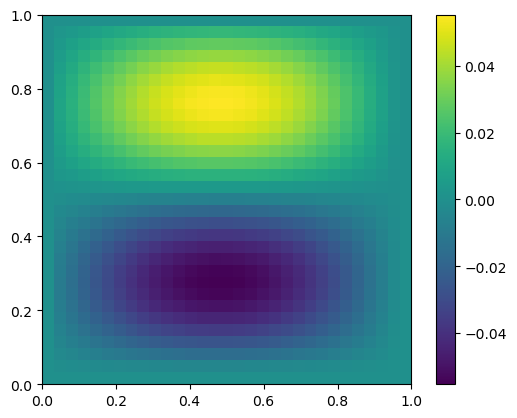

In [8]:
rhs = rhs_func(30)
plt.imshow(rhs, extent = [0,1,0,1])
print(rhs[0,:])
plt.colorbar()

In [9]:
def solve_scipy_gmres(U0, N, v=np.array([1, 1]), tol=1e-10):
    """Solve the diffusion-advection problem using GMRES for a grid of size (N+1) x (N+1)."""
    x0 = U0.flatten()  # Flatten the initial guess
    A = LinearOperator((x0.size, x0.size), matvec=lambda u_flat: lhs_func(u_flat.reshape((N+1, N+1)), N, v).flatten()) #Compute the linear operator
    b = rhs_func(N, v).flatten()  #b: (N+1)^2 vector for the rhs
    u_flat, exitCode = gmres(A, b, x0=x0, tol=tol)
    if exitCode != 0:
        print("GMRES did not converge")
    return u_flat.reshape((N+1, N+1))


In [10]:
def u_exact(N):
    x = np.linspace(0, 1, N + 1)
    y = np.linspace(0, 1, N + 1)
    X, Y = np.meshgrid(x, y)
    # Compute the exact solution at each grid point
    u_exact = np.sin(np.pi * X) * np.sin(2 * np.pi * Y)
    
    return u_exact

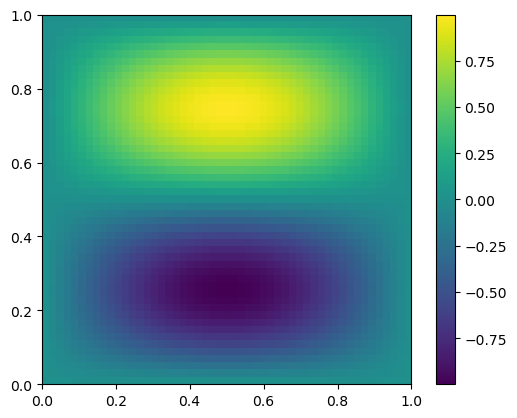

In [11]:
N = 50
u_ex = u_exact(N)
plt.imshow(u_ex, extent = [0,1,0,1])
plt.colorbar()


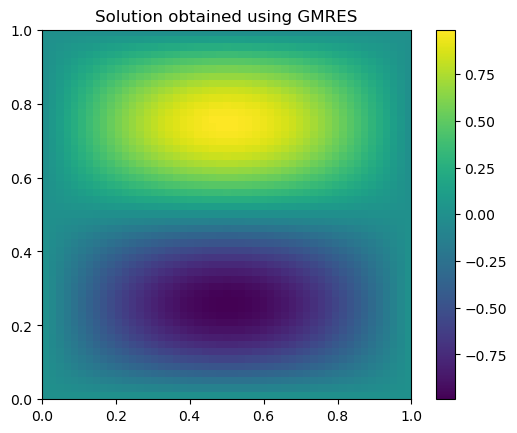

In [12]:
U0 = np.zeros((N+1,N+1))  #Start with the zero matrix
u = solve_scipy_gmres(U0, N, v=np.array([1, 1]), tol=1e-10)

# Plot the result
plt.imshow(u, extent=[0, 1, 0, 1])
plt.colorbar()
plt.title("Solution obtained using GMRES")
plt.show()

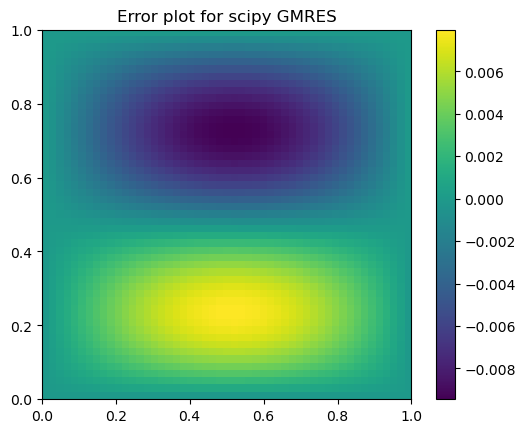

In [13]:
error = u - u_ex
plt.imshow(error, extent=[0, 1, 0, 1])
plt.colorbar()
plt.title("Error plot for scipy GMRES")
plt.show()

### Task (1)

Firstly we create a orthonormal basis for the Krylov subspace using Arnoldi's method

In [15]:
# Arnoldi function
def arnoldi(m, N, omega, v=np.array([1, 1])):
    """
    Arnoldi's method to generate an orthonormal basis for the Krylov subspace
    
    Parameters:
        v: The starting velocity field
        m: The number of basis vectors to compute.
        N: Grid size
        omega: Initial residual vector/ starting vector (N+1)^2
    
    Returns:
        V: The orthonormal basis vectors
        H: The upper Hessenberg matrix 
    """
    n = (N+1)**2  # Total number of grid points including boundary
    V = np.zeros((n, m+1))  # Orthonormal basis
    H = np.zeros((m+1, m))  # Upper Hessenberg matrix with m+1 rows
    omega = omega.flatten() #Make sure omega is in vector format
    
    # Normalize the first vector
    V[:,0] = omega / np.linalg.norm(omega)
    for j in range(m):
        # Compute the next vector using lhs_func to apply the operator
        w = lhs_func(V[:, j], N, v).flatten()  # Apply the operator to the vector V[:, j]
        # Orthogonalization against previous vectors
        for i in range(j+1):
            H[i, j] = np.dot(V[:, i], w)
            w -= H[i, j] * V[:, i]
        H[j + 1, j] = np.linalg.norm(w)
        if np.abs(H[j+1,j]) <= 1.e-12:
            print("H[j+1,j] is close to 0")            
            break
        V[:,j+1] = w/H[j+1,j]
    return V, H 



In [16]:
# Restarted GMRES method
def restarted_gmres(U0, m, N, tol=1e-4, v=np.array([1, 1])):
    """
    Restarted GMRES method using Arnoldi's method to solve Ax = b.

    Parameters:
        U0: The initial guess matrix 
        m: Number of iterations before restart.
        tol: Convergence tolerance.
        N: Grid size
        v: Advection speed
    
    Returns:
        x: The computed solution vector
        count: Number of iterations
        time: Converging time
    """
    start = perf_counter()
    x = U0.copy().flatten()      #Initial guess vector
    b = rhs_func(N, v).flatten()  # Right-hand side vector
    r_0 = b - lhs_func(x, N, v).flatten()  #Error matrix
    norm_r0 = np.linalg.norm(r_0)
    
    if norm_r0 < tol:  # Already converged
        return x, r_0, 0, 0
    
    omega_1 = r_0 / norm_r0  # Normalize the initial residual
    count = 0
    
    while True:
        V, H = arnoldi(m, N, omega=omega_1, v=v)  # Create an Arnoldi basis
        y = np.linalg.lstsq(H, np.dot(V.T, b - lhs_func(x, N, v).flatten()),rcond = None)[0]
        x += V[:, :y.size] @ y  # Only use the relevant part of V and y
        r_m = b - lhs_func(x, N, v).flatten()  # New residual
        count += 1
        
        if np.linalg.norm(r_m) / norm_r0 < tol:  # Check convergence
            break
            
        omega_1 = r_m / np.linalg.norm(r_m)  # Normalize the new residual
    res = np.reshape(r_m, (N+1,N+1))
    stop = perf_counter()
    time = stop - start
    return x.reshape((N+1, N+1)), res, count, time  # Reshape the solution into (N+1)x(N+1) grid

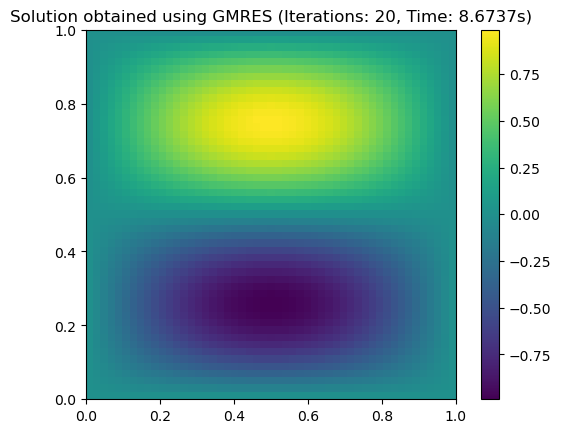

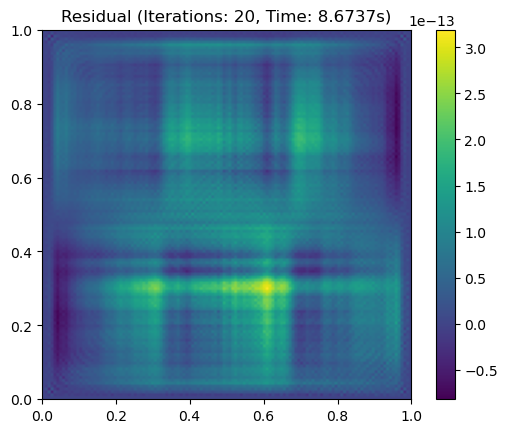

In [17]:
# Example usage
N = 2**7  # Grid size
U0 = np.zeros((N+1, N+1))  
u_gmres, res, count, time = restarted_gmres(U0, 60, N, tol=1e-10)

# Plot the result
plt.imshow(u, extent=[0, 1, 0, 1])
plt.colorbar()
plt.title(f"Solution obtained using GMRES (Iterations: {count}, Time: {time:.4f}s)")
plt.figure()

plt.imshow(res, extent=[0, 1, 0, 1])
plt.colorbar()
plt.title(f"Residual (Iterations: {count}, Time: {time:.4f}s)")
plt.show()

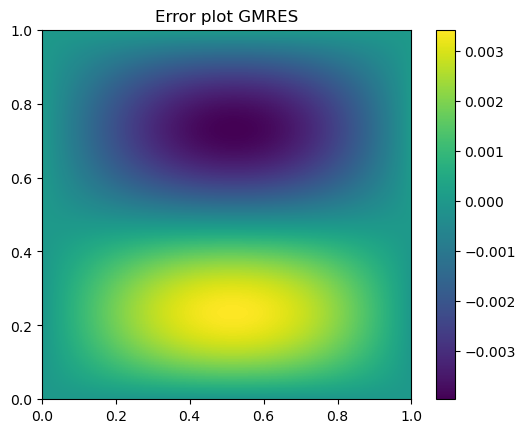

0.025


In [56]:
#Error between scipy.gmres and my gmres 
err2 = u_gmres - u_exact(2**7)
plt.imshow(err2, extent=[0, 1, 0, 1])
plt.colorbar()
plt.title("Error plot GMRES")
plt.show()
h = 1/N
print(h)

Konvergere no til omtrent riktig løsning, og trur erroren e innafor med tanke på at schemen e o(h). 

### Task (2)

First define the jacobi iteration, residual, restriction and interpolation functions.

In [21]:
def jacobi_relax(u, rhs, omega, N, nu, v = np.array([1,1])):
    """
    Perform weighted Jacobi iterations with upwind differencing for advection.
    
    Parameters:
        u: Initial guess (N+1)x(N+1) matrix.
        rhs: Right-hand side (N+1)x(N+1) matrix.
        omega: Relaxation parameter.
        N: Grid size.
        nu: Number of Jacobi iterations.
        v: Velocity field [v_x, v_y].
        
    Returns:
        Updated solution u after nu iterations.
    """
    h = 1 / N
    index = np.arange(1, N)  # Indices corresponding to internal nodes
    ixy = np.ix_(index, index)
    ixm_y = np.ix_(index - 1, index)  # i-1, j
    ixp_y = np.ix_(index + 1, index)  # i+1, j
    ix_ym = np.ix_(index, index - 1)  # i, j-1
    ix_yp = np.ix_(index, index + 1)  # i, j+1
    
    div = (4 + v[0] * h + v[1] * h) # Denominator includes advection terms
    for _ in range(nu):
        u_new = np.zeros_like(u)  # Create a copy to avoid overwriting in the same iteration
        # Jacobi iteration with upwind differencing for advection
        u_new[ixy] = ((1 - omega) * u[ixy] + 
                     omega*( (u[ixp_y] + u[ixm_y] * (1 + v[0] * h) + 
                      u[ix_yp] + u[ix_ym] * (1 + v[1] * h))/div + (rhs[ixy]/div) ))
        u = u_new  #Update the solution
    return u

    
def residual(u, rhs, N, v = np.array([1,1])):
    """
    Compute the residual rf = rhs - A @ u, where A is the discretized operator.
    
    Parameters:
        u: Current solution (N+1)x(N+1) matrix.
        rhs: Right-hand side (N+1)x(N+1) matrix.
        N: Grid size.
        
    Returns:
        Residual matrix.
    """
    rhs = np.reshape(rhs,(N+1,N+1)) #In case rhs is not in matrix format
    rf = rhs - lhs_func(u, N, v=v)
    return rf

def restriction(e, N):
    """
    Restrict the error from the fine grid to the coarse grid using a 2D full-weighting restriction.

    Parameters:
        e: Error matrix on the fine grid (N+1)x(N+1).
        N: Grid size of the fine grid, allways choose N to be even.
        
    Returns:
        Restricted error matrix on the coarse grid ((N//2)+1)x((N//2)+1).
    """
    # Calculate the coarse grid size
    Nc = N // 2
    rc = np.zeros((Nc + 1, Nc + 1))
    
    # Full-weighting restriction for the interior points
    for i in range(1, Nc):
        for j in range(1, Nc):
            rc[i, j] = (1/16) * (
                4 * e[2*i, 2*j] +         # Center point
                2 * (e[2*i-1, 2*j] + e[2*i+1, 2*j] + e[2*i, 2*j-1] + e[2*i, 2*j+1]) +  # Adjacent points
                (e[2*i-1, 2*j-1] + e[2*i-1, 2*j+1] + e[2*i+1, 2*j-1] + e[2*i+1, 2*j+1])  # Diagonal points
            )
    
    #Linear restriction along the boundary edges 
    for j in range(1, Nc):
        rc[0, j] = (1/4)*(e[0,2*j-1] + 2*e[0,2*j] + e[0,2*j+1])
        rc[-1, j] = (1/4)*(e[-1,2*j-1] + 2*e[-1,2*j] + e[-1,2*j+1])
        rc[j, 0] = (1/4)*(e[2*j-1,0] + 2*e[2*j,0] + e[2*j+1,0])
        rc[j, -1] = (1/4)*(e[2*j-1,-1] + 2*e[2*j,-1] + e[2*j+1,-1])
        
    #Corners
    rc[0, 0] = e[0, 0]
    rc[0, -1] = e[0, -1]
    rc[-1, 0] = e[-1, 0]
    rc[-1, -1] = e[-1, -1] 

    return rc


def interpolation(e, N):
    """
    Perform interpolation (prolongation) from the coarse grid to the fine grid
    as 4 times the transpose of the restriction operator.

    Parameters:
        e: Error matrix on the coarse grid (N//2 +1)x(N//2 +1).
        N: Grid size of the fine grid, allways choose N to be even.

    Returns:
        Interpolated error matrix on the fine grid (N+1)x(N+1).
    """
    Nc = N//2
    ef = np.zeros((N + 1, N + 1))
    
    # Interpolate by setting ef to be 4 times the transpose of restriction
    for i in range(0, Nc):
        for j in range(0, Nc):
            ef[2*i, 2*j] =  e[i, j]  # Center point from coarse grid
            ef[2*i+1, 2*j] = (1/2) * (e[i, j] + e[i+1, j])  # Horizontal interpolation
            ef[2*i, 2*j+1] = (1/2) * (e[i, j] + e[i, j+1])  # Vertical interpolation
            ef[2*i+1, 2*j+1] = (1/4) * (e[i, j] + e[i+1, j] + e[i, j+1] + e[i+1, j+1])  # Diagonal interpolation

    # Interpolate the boundary edges which is not captured by the previous loop, where I use linear interpolation along the edges
    for j in range(0, Nc):
        
        #Right boundary
        ef[-1, 2*j] = e[-1, j]
        ef[-1, 2*j +1] = (1/2) * (e[-1, j] + e[-1, j+1]) 
        
        
        #Bottom boundary (y indices goes from top to bottom)
        ef[2*j, -1] = e[j, -1] 
        ef[2*j+1, -1] =(1/2) * (e[j, -1] + e[j+1, -1])
        

    #Corners
    ef[0, 0] = e[0, 0]
    ef[0, -1] = e[0, -1]
    ef[-1, 0] = e[-1, 0]
    ef[-1, -1] = e[-1, -1]
        
    return ef


Original matrix (fine grid):
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1.]
 [1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1.]
 [1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1.]
 [1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1.]
 [1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1.]
 [1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1.]
 [1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1.]
 [1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1.]
 [1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

Restricted matrix (coarse grid):
[[1.         1.   

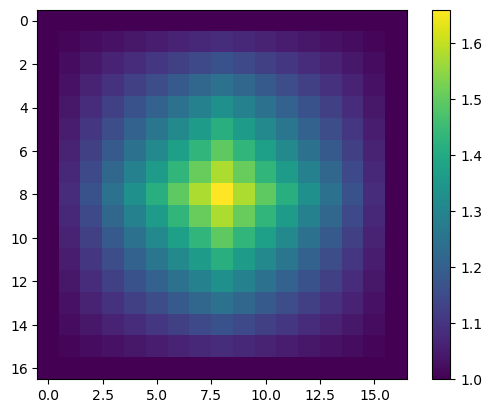

In [22]:
N = 2**4 # Fine grid size for restriction
mat = np.ones((N+1, N+1))
mat[4:-4,4:-4] = 2*np.ones((N-7,N-7))
rc = restriction(mat, N)
rc = restriction(rc, N//2)
rc = restriction(rc, N//4)
ef = interpolation(rc, N//4)
ef = interpolation(ef,N//2)
ef = interpolation(ef,N)
print("Original matrix (fine grid):")
print(mat)
print("\nRestricted matrix (coarse grid):")
print(rc)
print("\nInterpolated matrix (fine grid):")
print(ef)

plt.imshow(ef)
plt.colorbar()

Make the multigrid V-cycle function

In [80]:
def mgv(u0, rhs, N, nu1, nu2, level, max_level, v = np.array([1,1])):
    """
    Perform one multigrid V-cycle on the 2D advection-diffusion equation.

    Parameters:
        u0: Initial guess (N+1)x(N+1) matrix.
        rhs: Right-hand side (N+1)x(N+1) matrix.
        N: Grid size.
        nu1: Number of pre-smoothings.
        nu2: Number of post-smoothings.
        level: Current level of the V-cycle.
        max_level: Total number of levels, remember to choose this such that N // (2**max_level) gives a square matrix and not zero
        v: Velocity field (not used in the given context).
        
    Returns:
        u: The computed solution vector
        count: Number of iterations
        time: Converging time
        
    """
    start = perf_counter()
    count = 0
    if level == max_level:
        # On the coarsest level, solve using GMRES
        u, res, count, time = restarted_gmres(u0, max_level, N, tol=1e-10, v=np.array([1, 1]))
        plt.imshow(u)
        plt.title(f'coursest level, shape: {np.shape(u)}')
        plt.colorbar()
        plt.show()
        print(np.max(u))
    else:
        u = jacobi_relax(u0, rhs, 2/3, N, nu1) # Pre-smoothing
        plt.imshow(u)
        plt.title(f'pre, shape: {np.shape(u)}')
        plt.colorbar()
        plt.show()
        rf = residual(u, rhs, N)         # Compute the residual
        rc = restriction(rf, N)          # Restrict the residual to a coarser grid
        count +=1
        ec, _, _,_= mgv(np.zeros_like(rc), rc,  N//2, nu1, nu2, level + 1, max_level)   #Recursive call on the coarser grid
        ef = interpolation(ec, N)   # Interpolate the error back to the fine grid
        u += ef   # Update the solution with the interpolated error
        plt.imshow(u)
        plt.title(f'post, shape: {np.shape(u)}')
        plt.colorbar()
        plt.show()
        u = jacobi_relax(u,rhs,2/3,N,nu2)  # Post-smoothing
        
        res = ef
    stop = perf_counter()
    time = stop - start
    return u, res, count, time

### Task (3)

Solve a problem

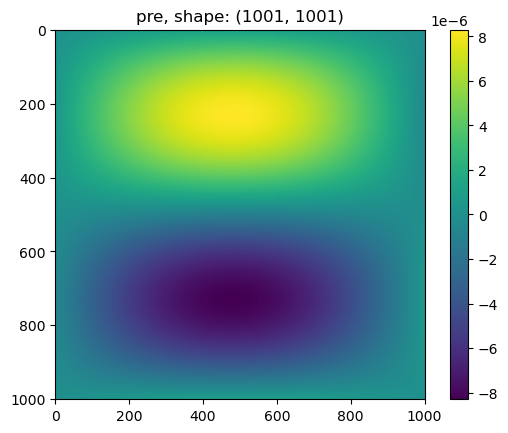

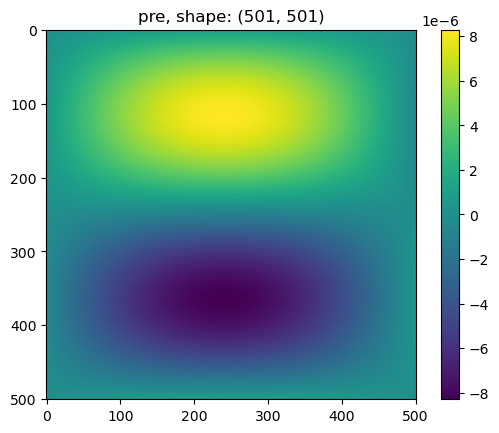

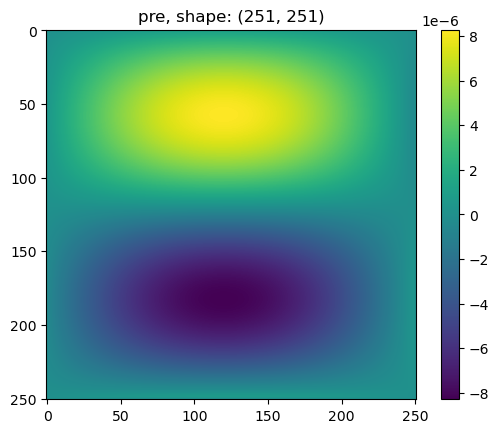

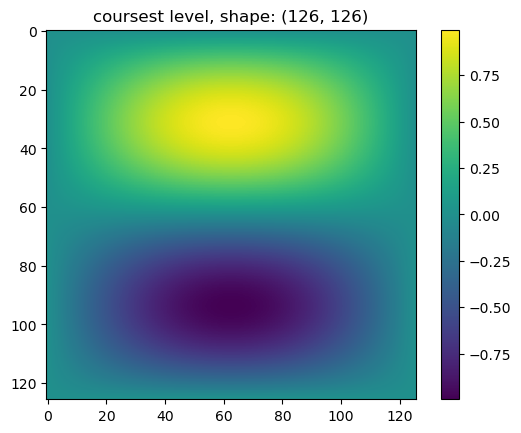

0.9958319481293316


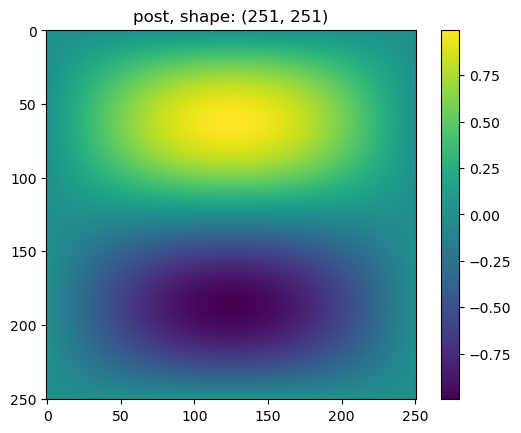

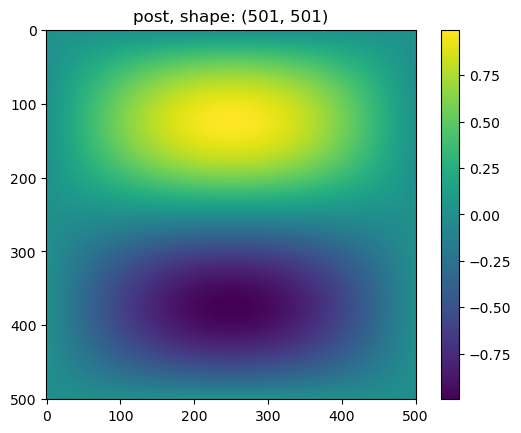

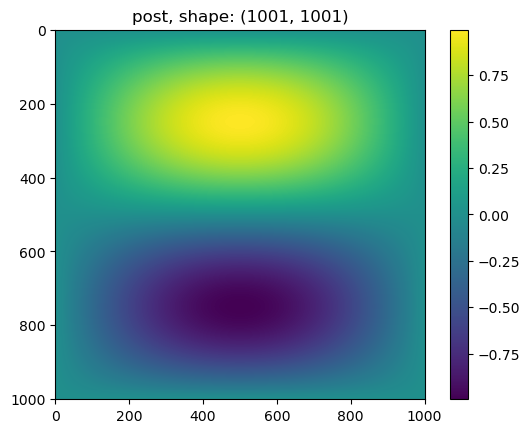

In [90]:
#Problems with the grid sizes in the lhs_func when the mgv function is called recursively
N = 1000
u0 = np.zeros((N+1,N+1))
rhs = rhs_func(N)

u_mgv, res_mgv, count_mgv, time_mgv = mgv(u0, rhs, N, nu1 = 1, nu2 = 1, level = 1, max_level= 4)

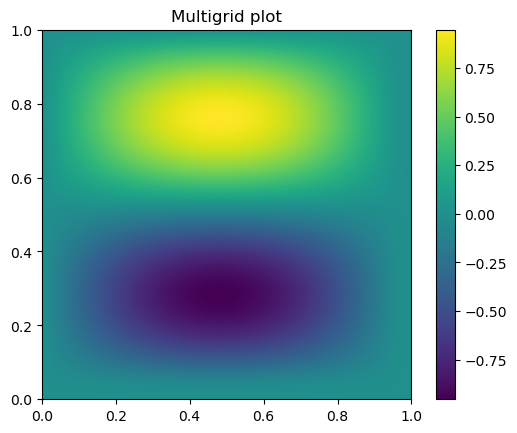

In [84]:

plt.imshow(u_mgv, extent=[0, 1, 0, 1])
plt.colorbar()
plt.title("Multigrid plot")
plt.show()

 h = 0.001


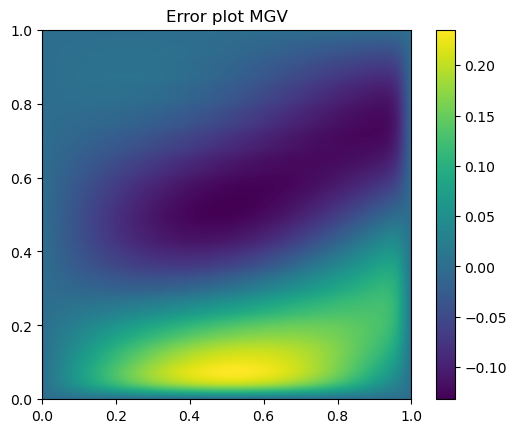

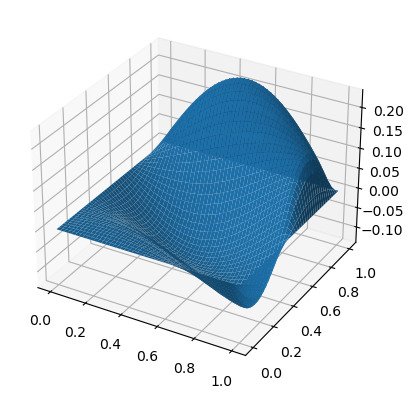

In [86]:
u_ex_2 = u_exact(N)
error_mgv = u_mgv - u_ex_2
plt.imshow(error_mgv, extent=[0, 1, 0, 1])
plt.colorbar()
plt.title("Error plot MGV")
x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)
print(f' h = {1/N}')
X,Y = np.meshgrid(x,y)
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
surf = ax.plot_surface(X,Y, error_mgv)



0.9918402472762309
-0.9933187666956684


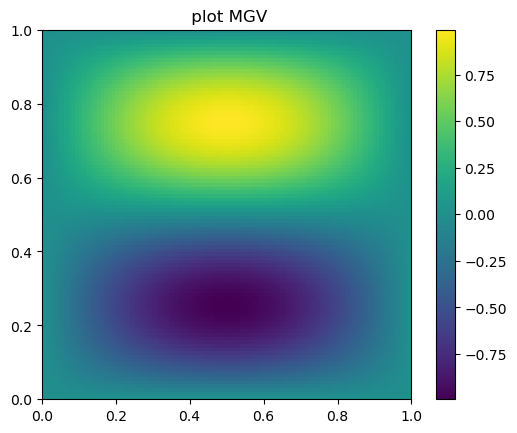

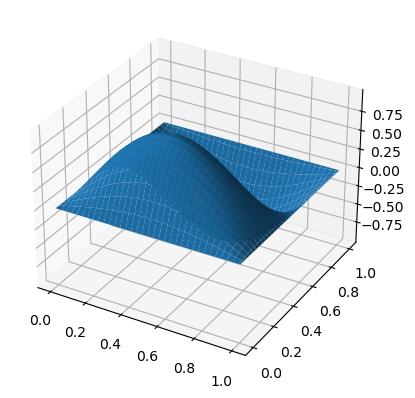

In [29]:
plt.imshow(u_mgv, extent=[0, 1, 0, 1])
plt.colorbar()
plt.title(" plot MGV")
print(np.max(u_mgv))
print(np.min(u_mgv))

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)
X,Y = np.meshgrid(x,y)
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
surf = ax.plot_surface(X,Y, u_mgv)

### Task (4) 

Need to change the vector product Ax with the lhs_func.

In [100]:
def precon_gmres(U0, m, N, nu1, nu2, level, max_level, tol=1e-4):
    start = perf_counter() 
    x = U0.copy().flatten()
    b = rhs_func(N)
    r0 = b - lhs_func(x,N)
    norm_r0 = np.linalg.norm(r0.flatten())
    z, _, _,_ = mgv(np.zeros((N+1, N+1)),r0, N, nu1, nu2, level, max_level)
    z = z.flatten()
    norm_z0 = np.linalg.norm(z)

    if norm_r0 < tol:  # Already converged
        return x, r_0, 0, 0
        
    omega_1 = z / norm_z0 # Normalize the initial residual
    count = 0
    
    while True:
        # Create Arnoldi basis
        r_m =  b - lhs_func(x, N)  # New residual matrix
        Z, H = arnoldi(m, N, omega=omega_1)
        e1 = np.zeros(H.shape[0])
        e1[0] = np.linalg.norm(r_m)  # Use the norm of the preconditioned residual
        y = np.linalg.lstsq(H, e1, rcond=None)[0]
        x += Z[:, :y.size] @ y  # Only use the relevant part of V and y
        r_m =  b - lhs_func(x, N)  # New residual matrix
        z_m, _, _,_ = mgv(np.zeros_like(r_m),r_m, N, nu1, nu2, 1, max_level) #New preconditioned residual
        z_m = z_m.flatten()
        # Update omega_1 for the next Arnoldi iteration
        omega_1 = z_m / np.linalg.norm(z_m)
        count += 1
        print(f"Iteration {count}, Residual Norm: {np.linalg.norm(r_m)}")
    
    # Check for convergence
        if np.linalg.norm(r_m) / norm_r0 < tol:
            break
    
    # Safety limit
        if count > 20:
            print("Warning: Maximum iterations reached!")
            break

    res = np.reshape(r_m, (N+1, N+1))
    stop = perf_counter()
    time = stop - start
    return x.reshape((N+1, N+1)),res, count, time


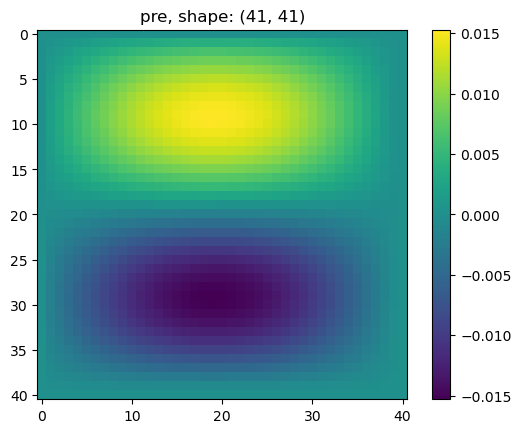

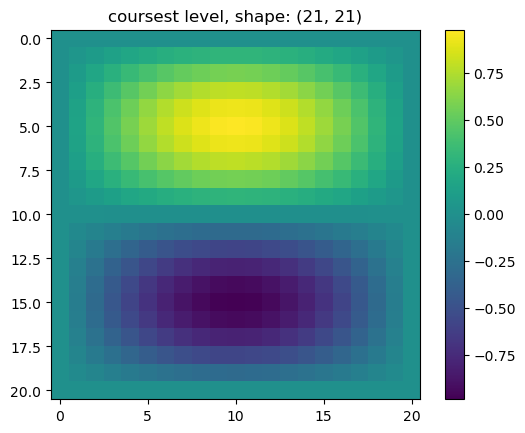

0.9807340680586668


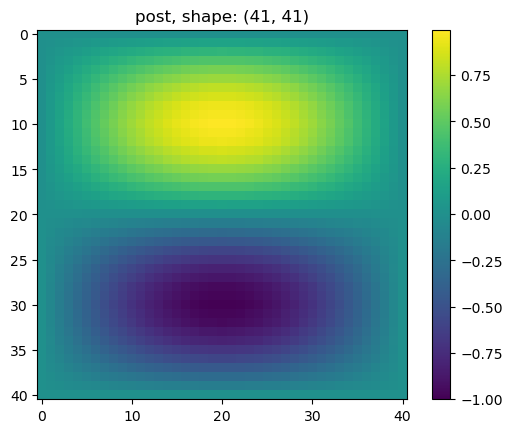

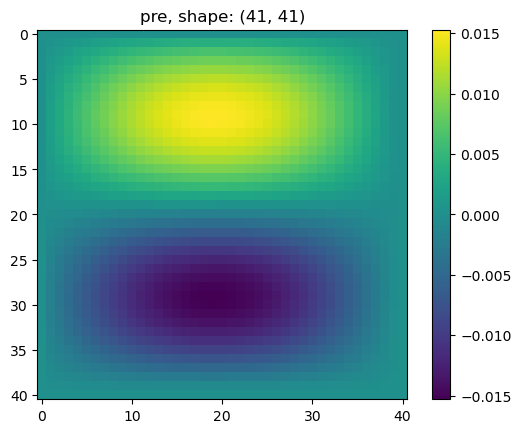

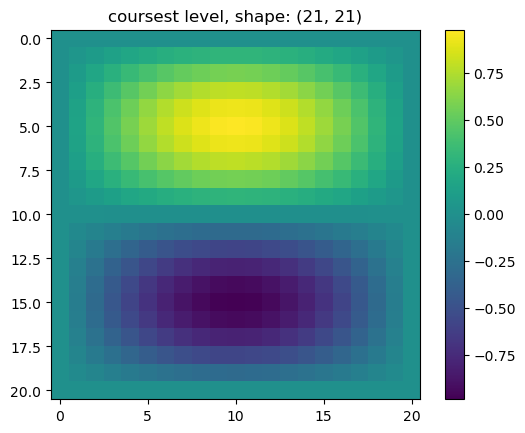

0.9807340680586668


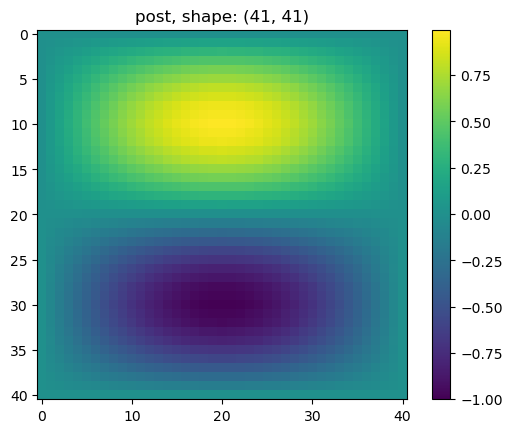

Iteration 1, Residual Norm: 0.62275947111867


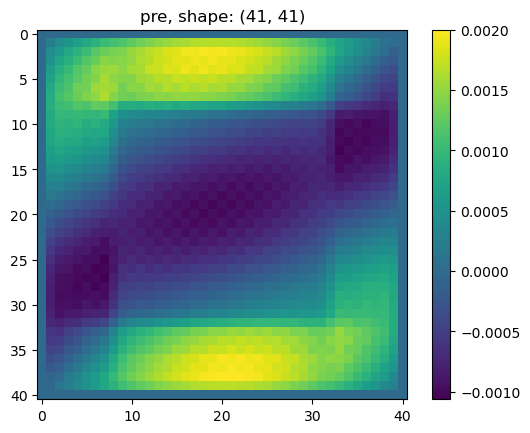

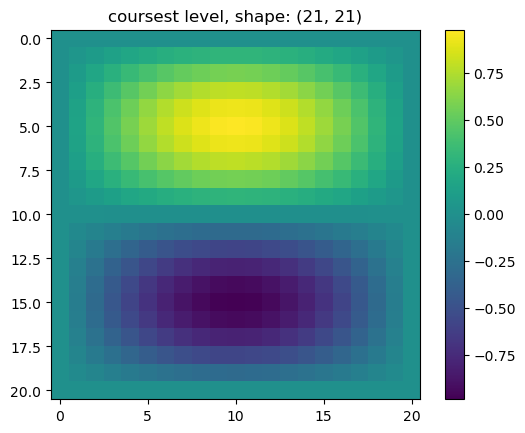

0.9807340680586668


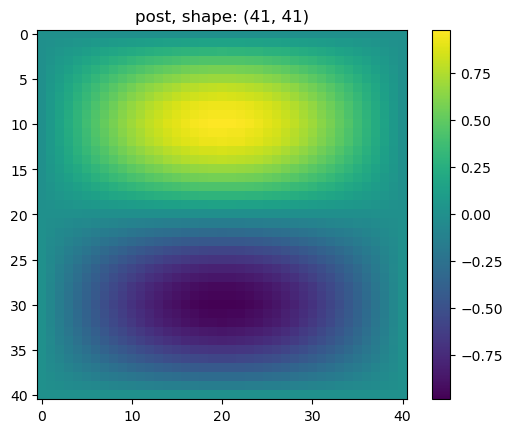

Iteration 2, Residual Norm: 0.07712527455938545


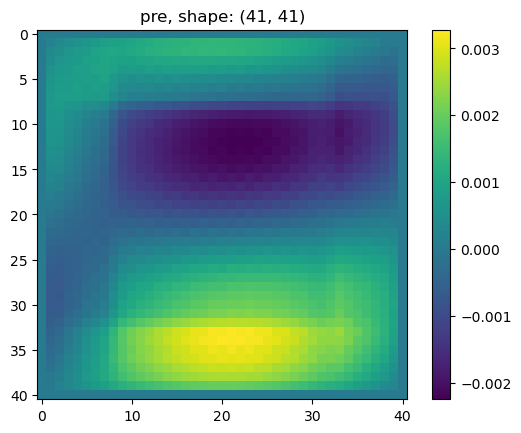

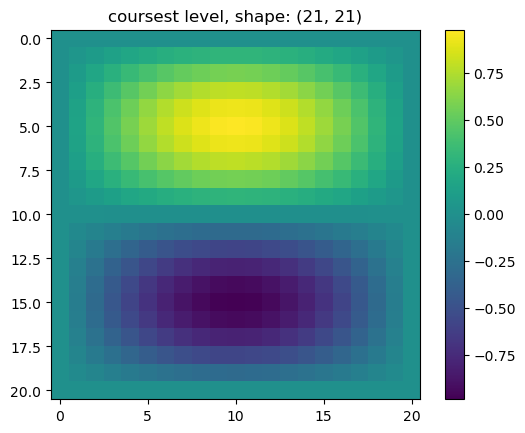

0.9807340680586668


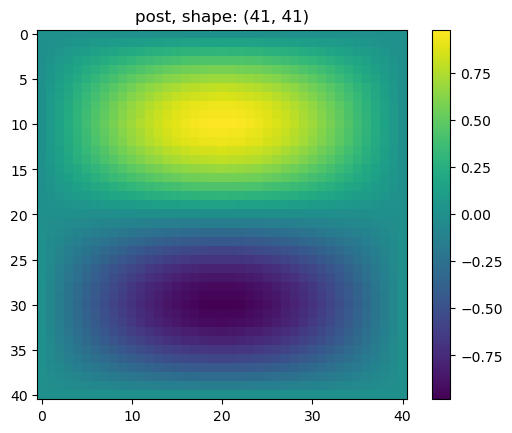

Iteration 3, Residual Norm: 0.11183138101434026


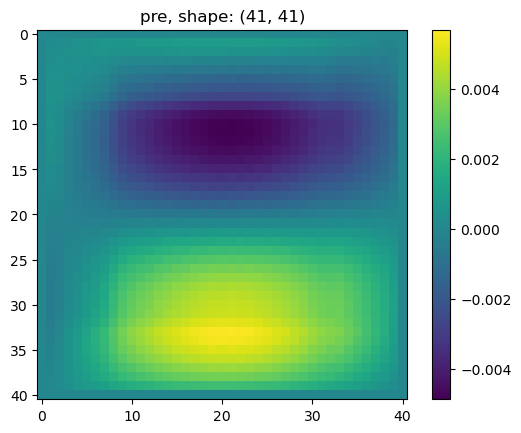

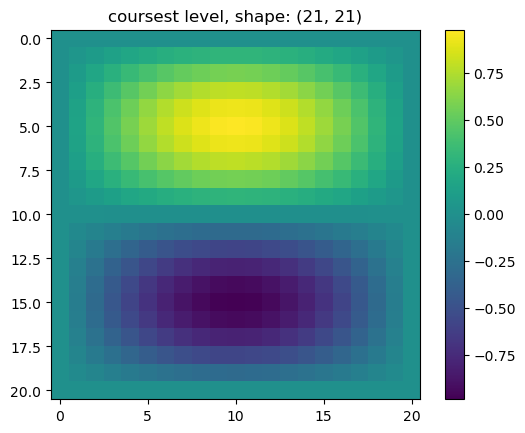

0.9807340680586668


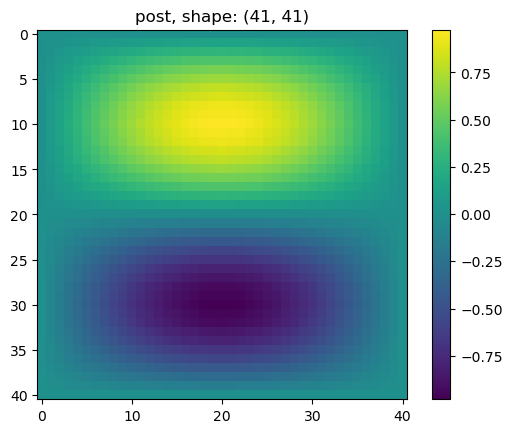

Iteration 4, Residual Norm: 0.20718791079050405


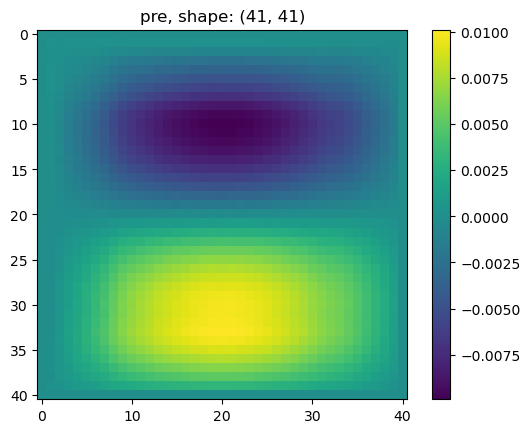

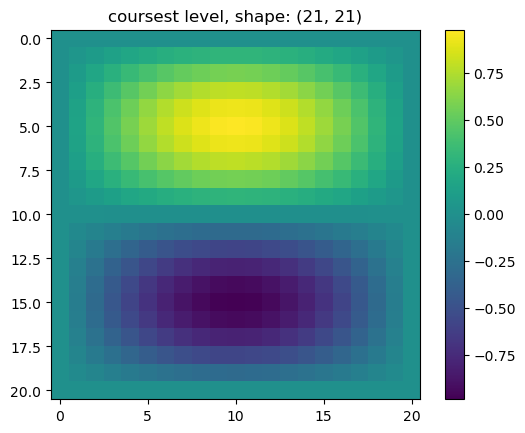

0.9807340680586668


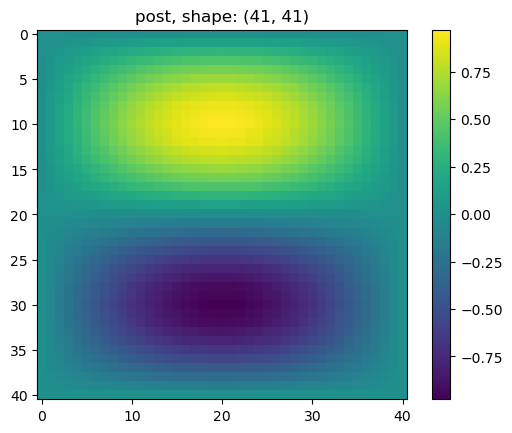

Iteration 5, Residual Norm: 0.40638041001425024


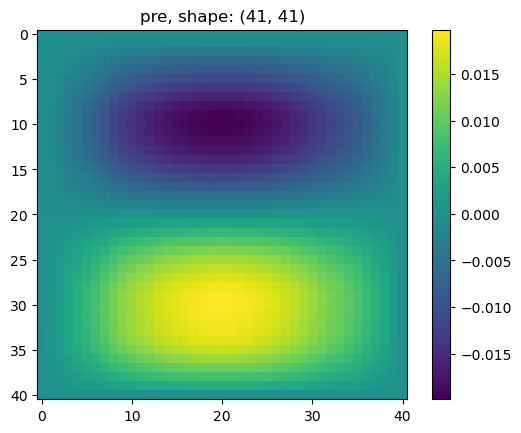

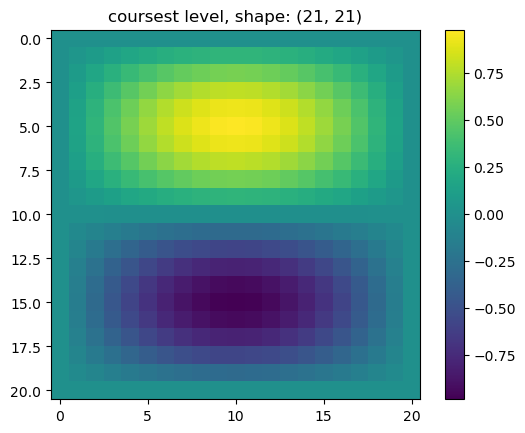

0.9807340680586668


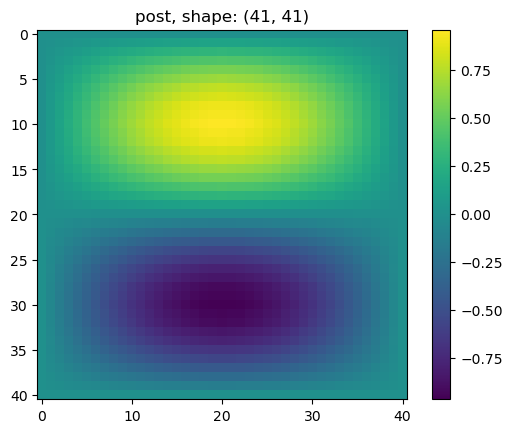

Iteration 6, Residual Norm: 0.8082744587065325


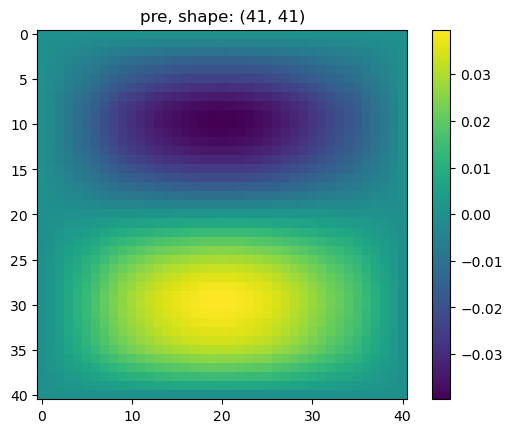

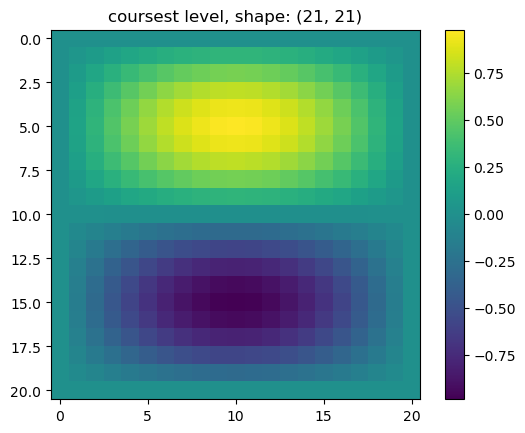

0.9807340680586668


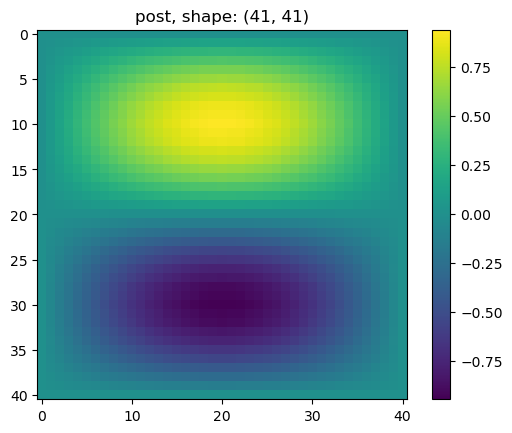

Iteration 7, Residual Norm: 1.6131090948822584


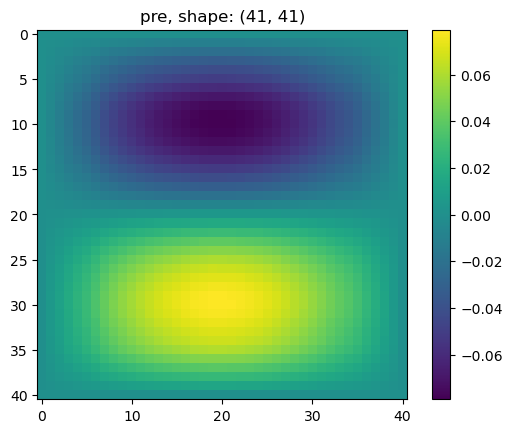

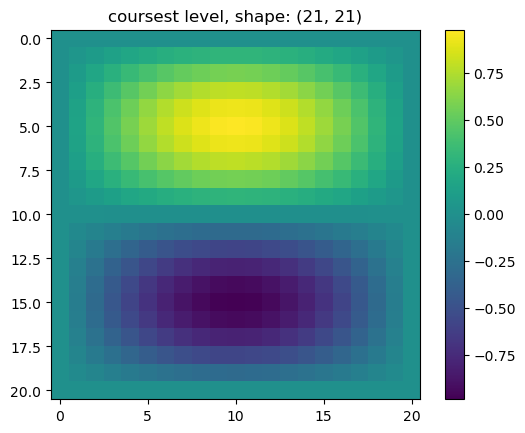

0.9807340680586668


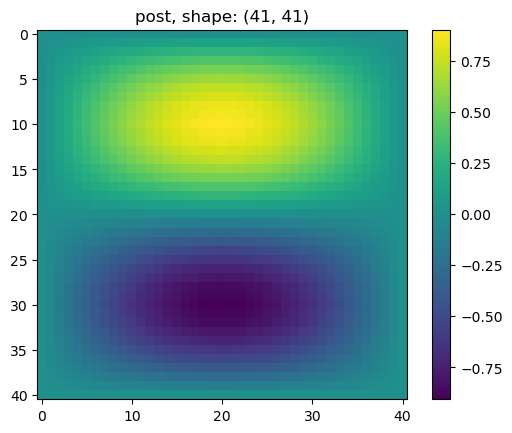

Iteration 8, Residual Norm: 3.2222493417403224


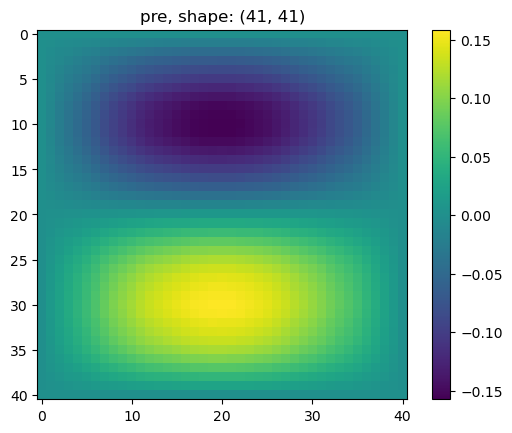

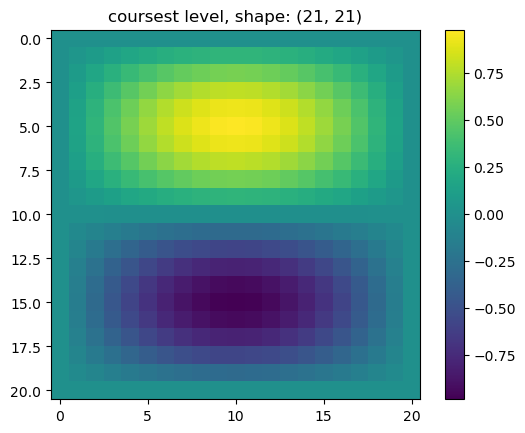

0.9807340680586668


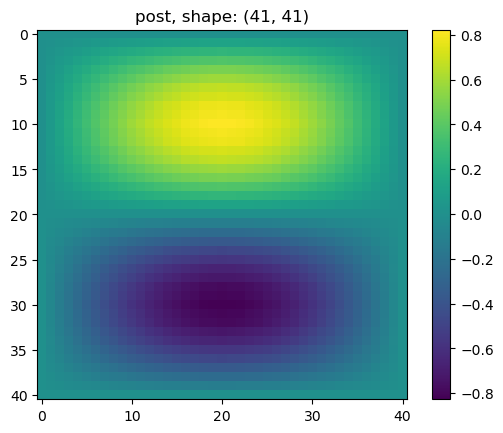

Iteration 9, Residual Norm: 6.437722253351167


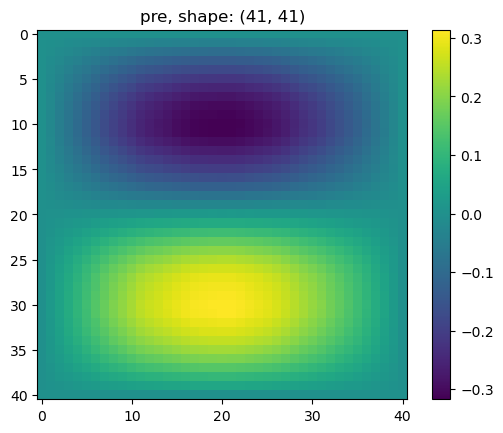

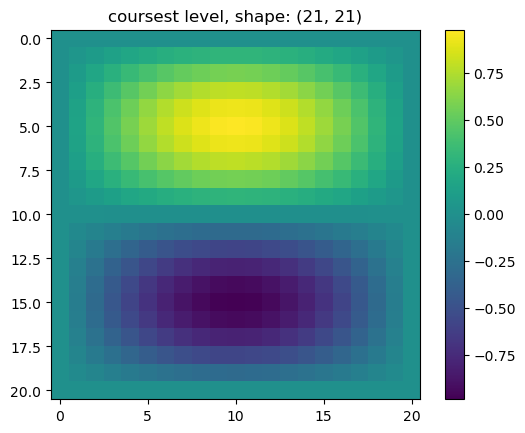

0.9807340680586668


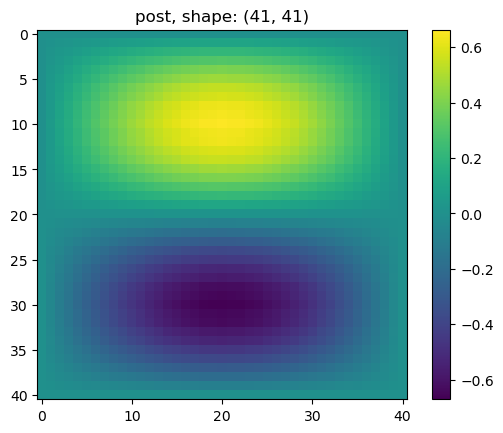

Iteration 10, Residual Norm: 12.85639218226171


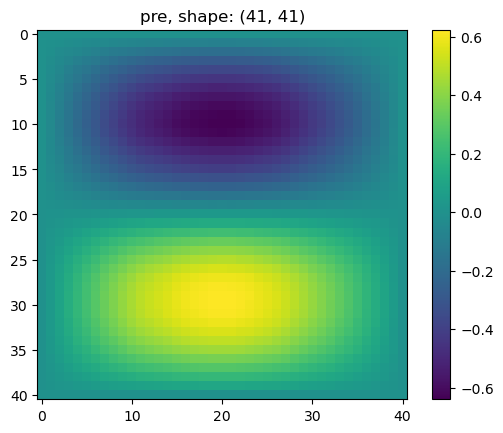

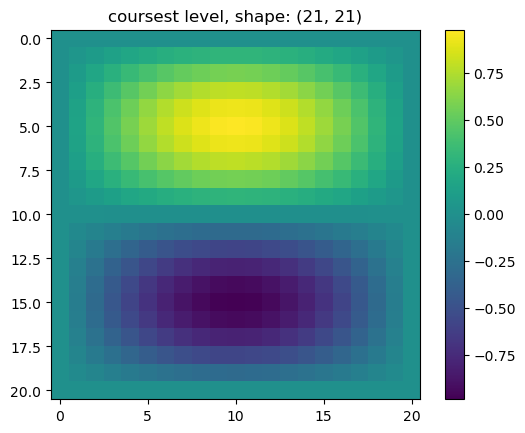

0.9807340680586668


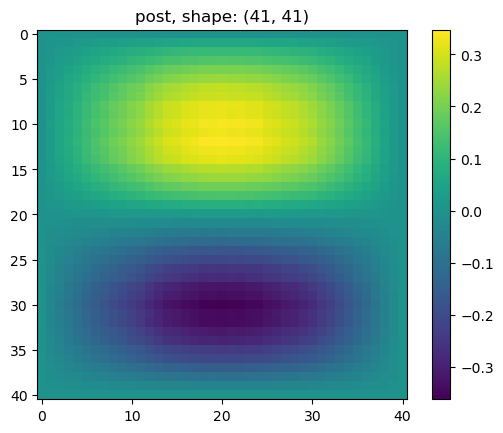

Iteration 11, Residual Norm: 25.66274927044089


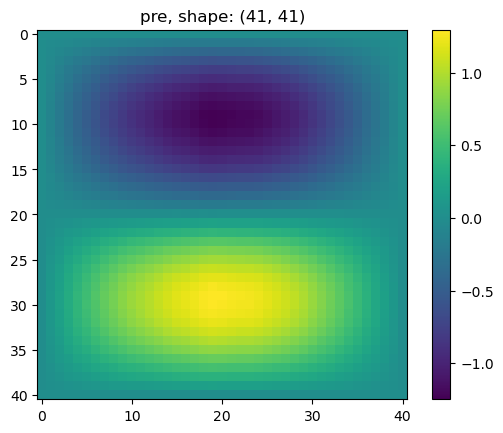

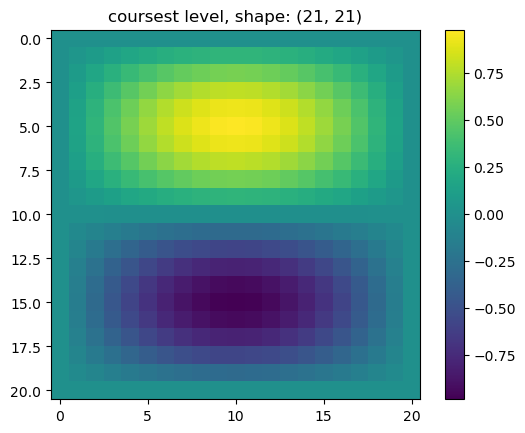

0.9807340680586668


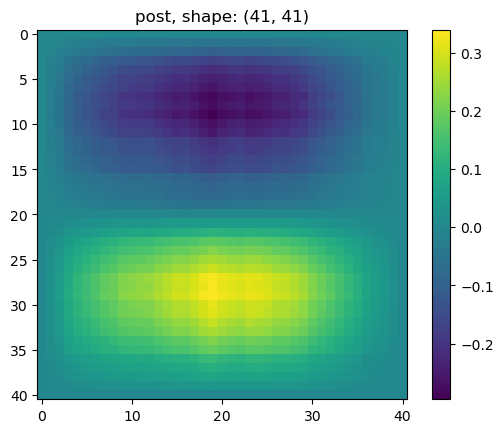

Iteration 12, Residual Norm: 51.11992341873271


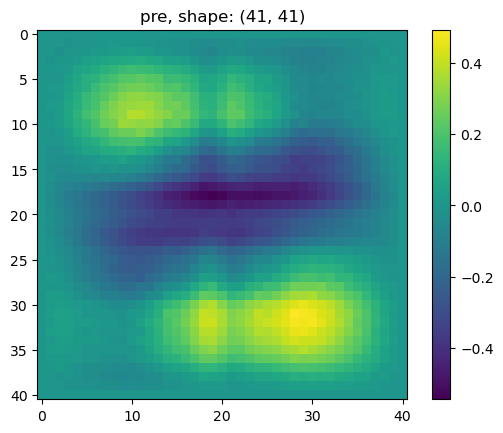

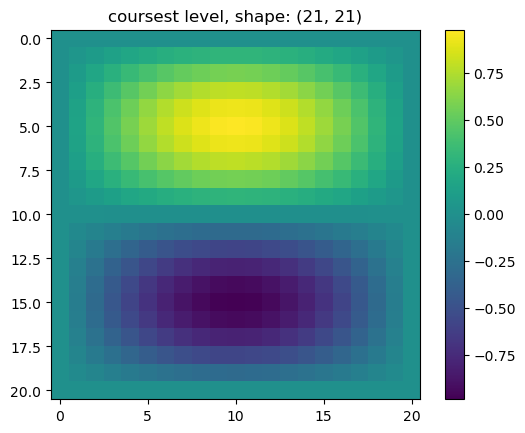

0.9807340680586668


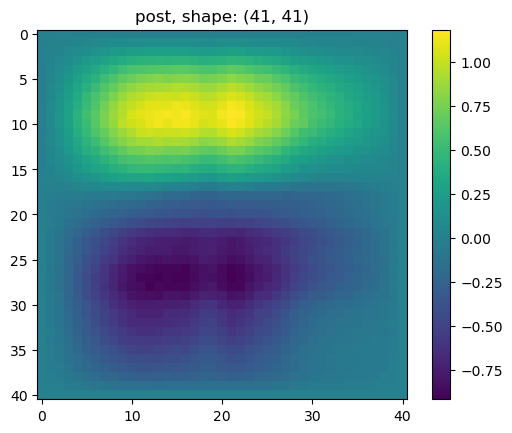

Iteration 13, Residual Norm: 16.271224721204256


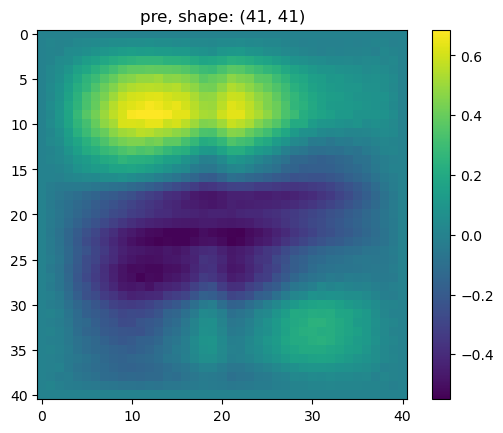

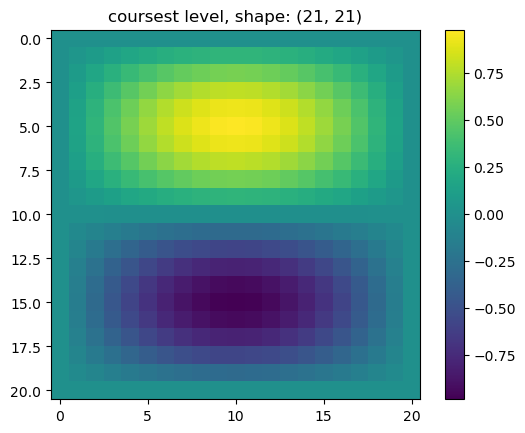

0.9807340680586668


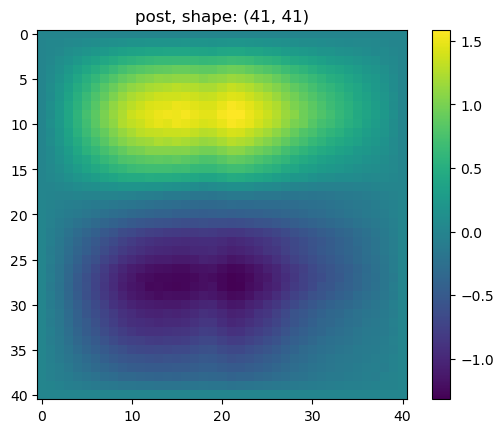

Iteration 14, Residual Norm: 21.508741166450232


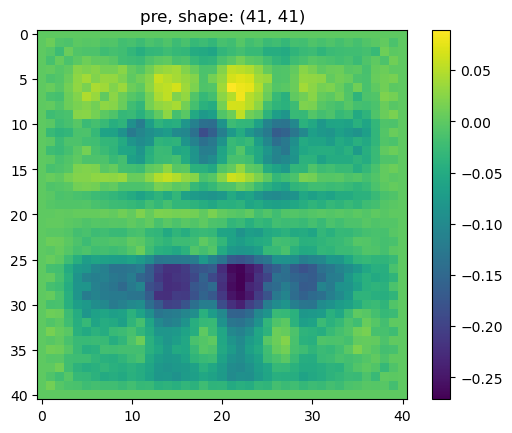

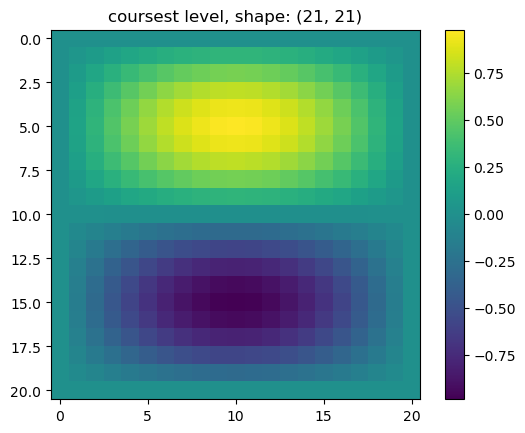

0.9807340680586668


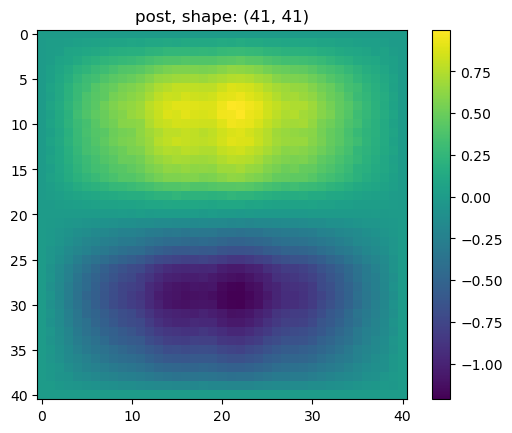

Iteration 15, Residual Norm: 5.846609999409833


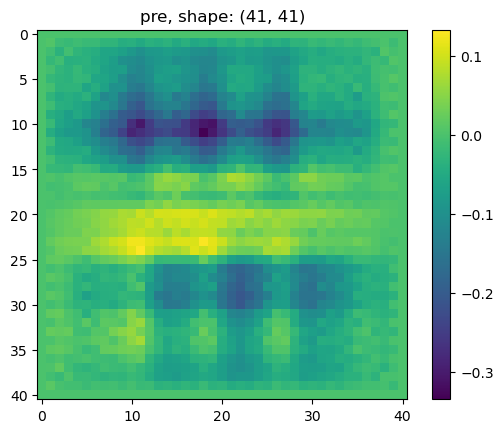

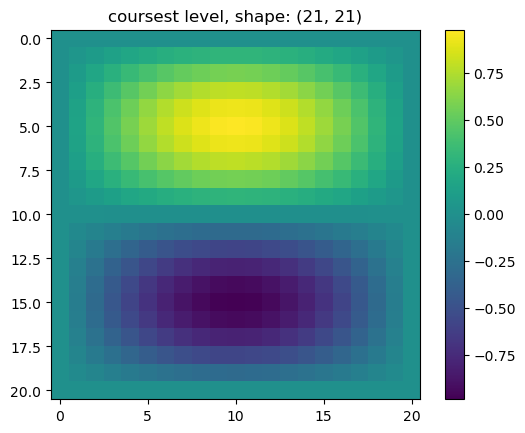

0.9807340680586668


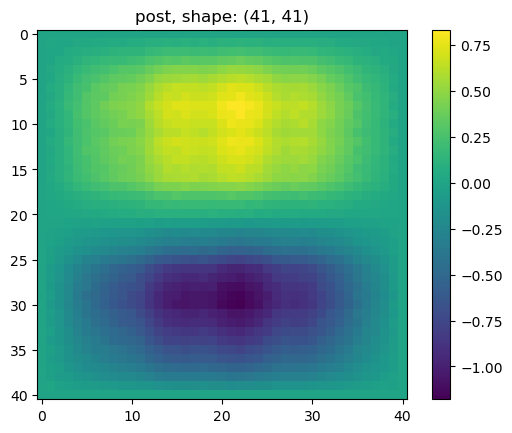

Iteration 16, Residual Norm: 7.2210869442068155


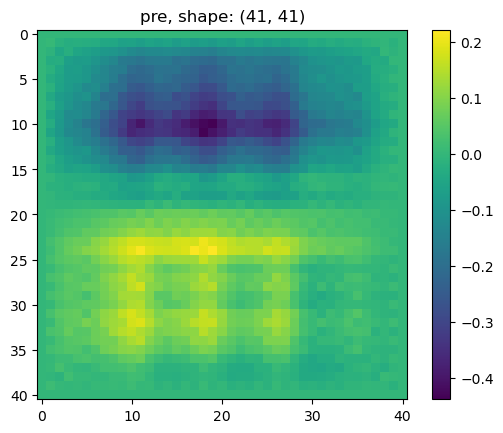

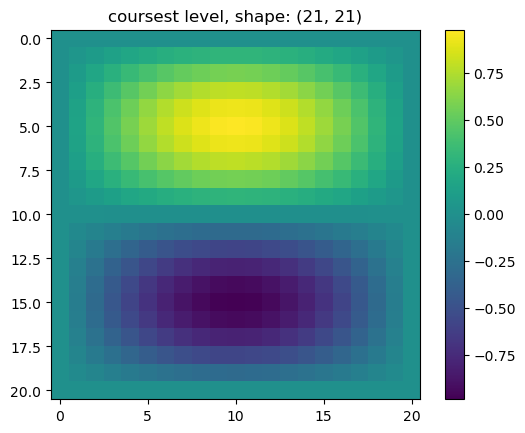

0.9807340680586668


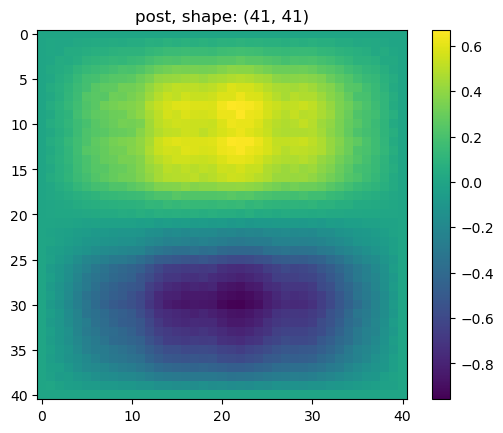

Iteration 17, Residual Norm: 10.664672447763584


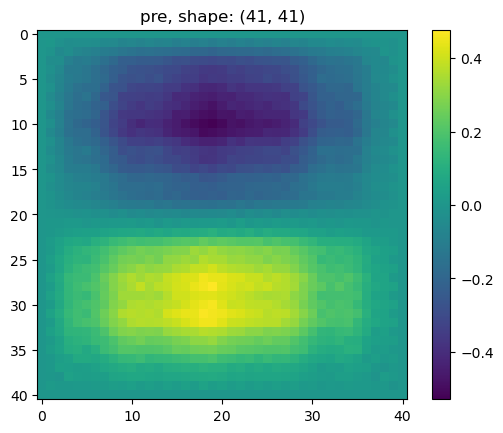

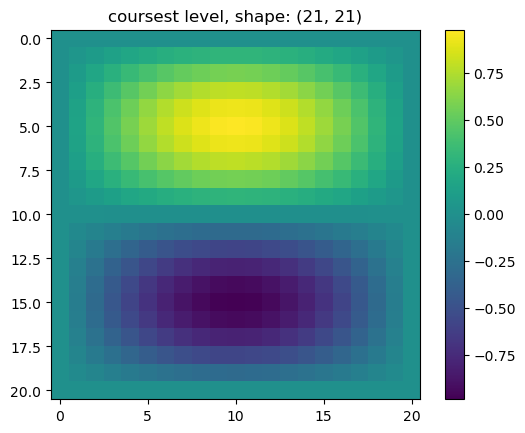

0.9807340680586668


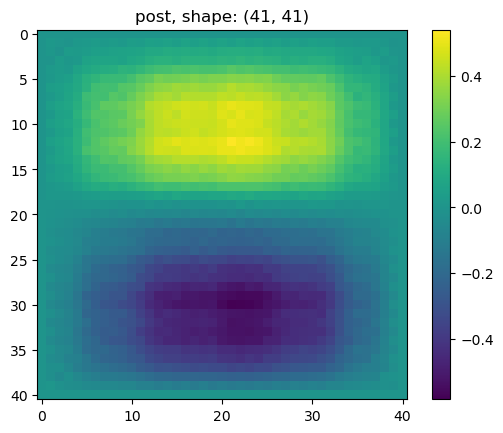

Iteration 18, Residual Norm: 18.492245434950043


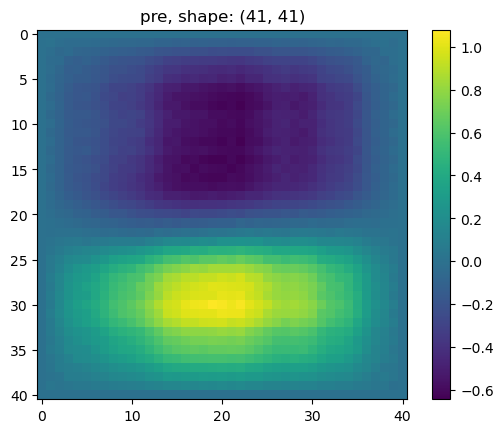

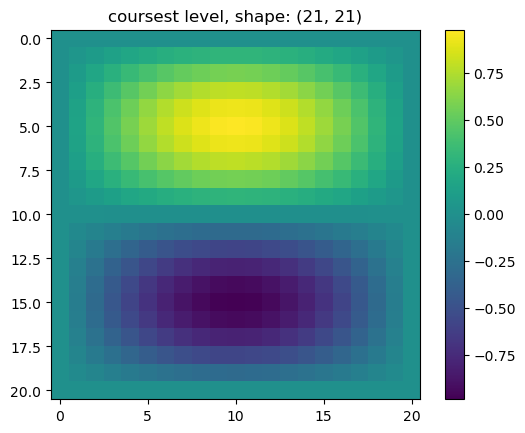

0.9807340680586668


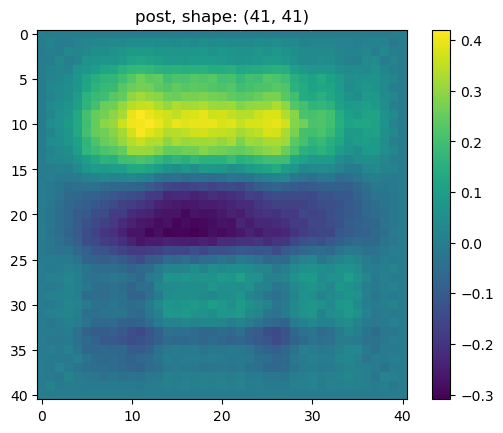

Iteration 19, Residual Norm: 34.31406752519576


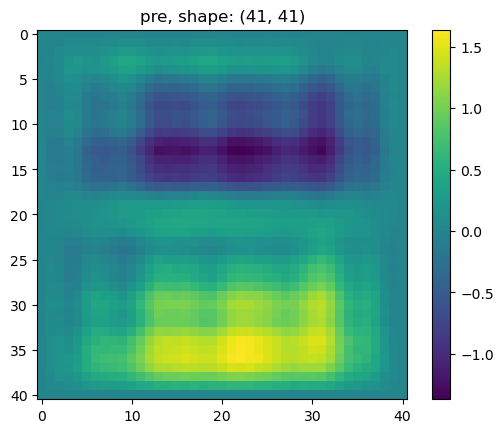

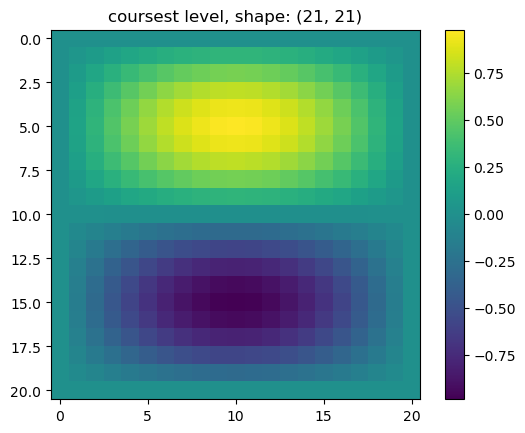

0.9807340680586668


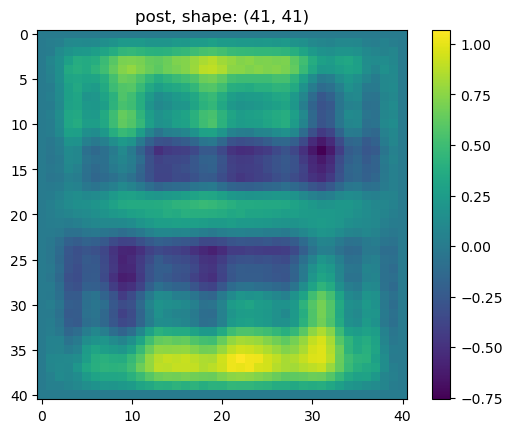

Iteration 20, Residual Norm: 50.27560159367579


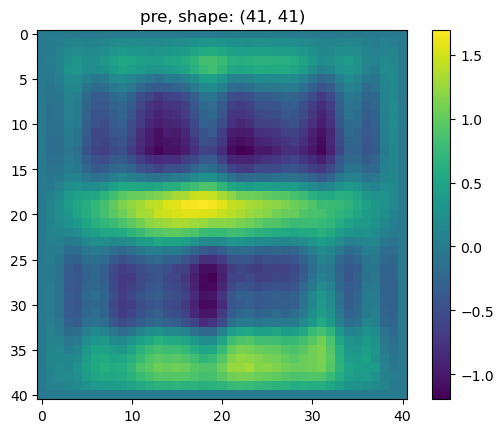

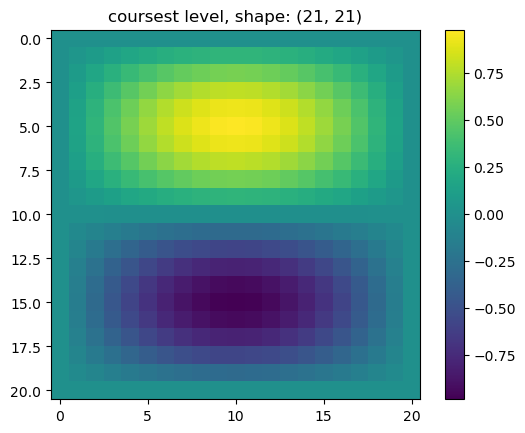

0.9807340680586668


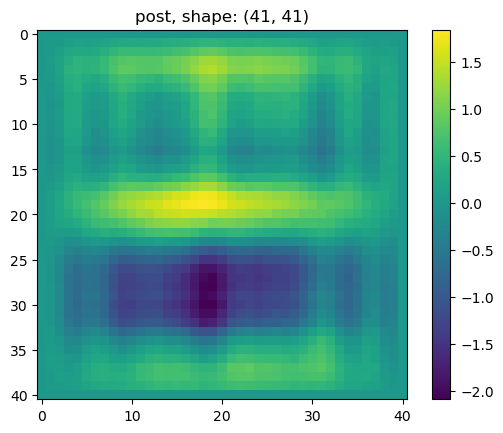

Iteration 21, Residual Norm: 47.62157810772928


In [102]:
N = 40
U0 = np.zeros((N+1,N+1))
rhs = rhs_func(N)
m = 10

x,res, count, time = precon_gmres(U0, m,N, nu1 =3, nu2 = 3, level = 1, max_level = 2, tol=1e-2)



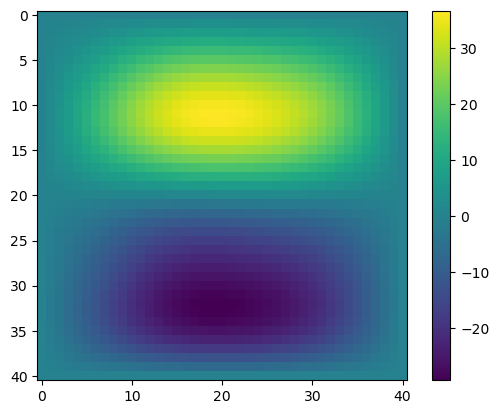

In [98]:
plt.imshow(x)
plt.colorbar()